<center><img src = "practicals/Images/ATU_Logo.jpg"></center>

<h2 style="color: #001a79;">Author: Sam Tracey</h2>
<h2 style="color: #001a79;">Student ID: G00398245</h2>
<h2 style="color: #001a79;">Topic: <a href="https://keras.io/examples/timeseries/timeseries_anomaly_detection/">Timeseries anomaly detection using an Autoencoder</a></h2>
<hr style="border-top: 1px solid #001a79;" />



<h2 style="color: #001a79;">Introduction</h2>

<p style="color: #001a79;"> Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research. </p>


<hr style="border-top: 1px solid #001a79;" />



In [275]:
# Python package to facilitate working with arrays.
import numpy as np

# Python package for data analysis and manipulation using dataframes.
import pandas as pd

# High level neural network API.
import tensorflow.keras as keras

# The original Keras tutorial imported layers from keras.layers.
# As this is only used in one cell (model = keras.Sequential) we will not import it here.
# Instead we will use keras.layers in the cell.

# Python package for data visualization.
import matplotlib.pyplot as plt

In [277]:
# Define the style to be used by Matplolib.pyplot.
plt.style.use('ggplot')

<h2 style="color: #001a79;">Data</h2>

<p style="color: #001a79;">The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection in streaming / real-time applications.<br>
There are two distinct data categories that benchmark scripts can be assessed against:<br><br>
- Real Data. Which is data collected from sources such as Amazon AWS, Ad Exchange or Twitter.<br>
- Artificial Data. Synthetic data that has been generated manually.<br><br>
This notebook uses The Artificial Datasets <code>art_daily_small_noise.csv</code> and <code>art_daily_jumpsup.csv</code>.<br><br>
More information about the NAB Benchmark and the data sets involved can be found at the links below. </p>

<p style="color: #001a79;"><b>The art_daily_small_noise.csv</b> dataset contains two columns of data - timestamp and value. Timestamp is used as the index. This data set has no anomalies and will be used for training.<br><br>
<b>The art_daily_jumpsup.csv</b> dataset contains the same columns as above. This dataset does contain an anomaly which we want our model to detect if possible.</p>



<hr style="border-top: 1px solid #001a79;" />



https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

In [278]:
# Note - we could have read the entire url using pandas.read_html but,
# in keeping with the tutorial, we will use the root url and read the data using pandas.read_csv.
# We also split the url into two parts to adhere to PEP8.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly appended to root url.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly appended to root url.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [279]:
# Check and verify urls created. (ctrl + click to open url in browser)
print(f'No anomaly url: {no_anomaly_url}')
print(f'With anomaly url: {with_anomaly_url}')

No anomaly url: https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv
With anomaly url: https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv


<p style="color: #001a79;">First, we will load and do some preliminary checks on the art_daily_small_noise.csv dataset.</p>

In [280]:
# Read the data file with no anomaly into a pandas dataframe.
# So as not to round the data on import we use float_precision='round_trip'.
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp", float_precision='round_trip')

In [281]:
# Changing the precision to 15 decimal places.
pd.set_option("display.precision", 15)

In [282]:
# Check the first five rows of the dataframe.
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324918539200002
2014-04-01 00:05:00,21.970327181999998
2014-04-01 00:10:00,18.624806031700000
2014-04-01 00:15:00,21.953683975900002
2014-04-01 00:20:00,21.909119730300002


In [283]:
# Get the actual value from the first row of the dataframe.
print(f'The first value is: {df_small_noise.iloc[0, 0]}')

The first value is: 18.324918539200002


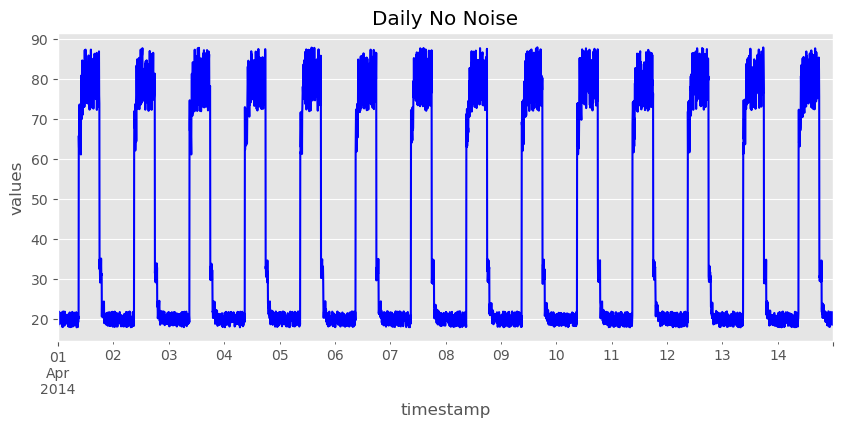

In [284]:
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_small_noise.plot(legend=False, ax=ax, ylabel='values',
                    title='Daily No Noise', color='blue');

<p style="color: #001a79;">Next, we will load and do some preliminary checks on the art_daily_jumpsup.csv dataset.</p>

In [285]:
# Read the data file with anomaly into a pandas dataframe.
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp",float_precision='round_trip')

In [286]:
# Check the first five rows of the dataframe.
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761251902999998
2014-04-01 00:05:00,20.500833286999999
2014-04-01 00:10:00,19.961641444500000
2014-04-01 00:15:00,21.490266073400001
2014-04-01 00:20:00,20.187739409799999


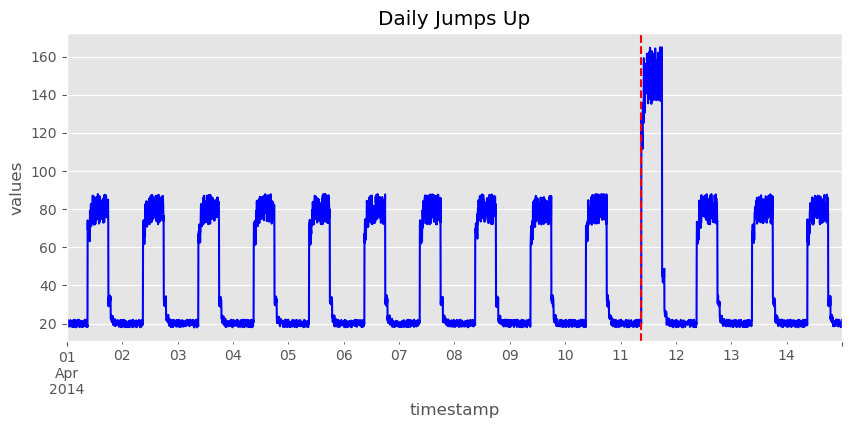

In [287]:
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax, ylabel='values',
                      title='Daily Jumps Up', color='blue')
# Add a vertical line to the plot where anomaly begins.
ax.axvline('2014-04-11 09:00:00', color='red', linestyle='--');
   

<h2 style="color: #001a79;">Exploratory Data Analysis</h2>

<p style="color: #001a79;"> There is very sparse data analysis carried out in the original tutorial on the Keras website. This is to be expected since the whole purpose of the tutorial is to give you an introduction to anomaly detection using Autoencoders. However, in his recent paper "How to avoid machine learning pitfalls: a guide for academic researchers", Michael Lones gives some salient advice.</p>

> It's normal to want to rush into training and evaluating models, but it's important to<br>
take the time to think about the goals of a project, to fully understand the data that<br>
will be used to support these goals, to consider any limitations of the data that need to<br>
be addressed, and to understand what's already been done in your field. If you don't do<br>
these things, then you may end up with results that are hard to publish, or models that<br>
are not appropriate for their intended purpose.
</p>

<p style="color: #001a79;"> In this section, I will carry out some basic Exploratory Data Analysis on the two data sets used in this tutorial. </p>

<hr style="border-top: 1px solid #001a79;" />

In [288]:
# Generate some basics statistics for the small_noise data frame.
df_small_noise.describe()

,value
count,4032.000000000000000
mean,42.438353335806646
std,28.077122281262515
min,18.000964018700000
25%,19.841390243050000
50%,21.608486758200002
75%,75.450281655550000
max,87.976128326399987


In [289]:
# Generate some basics statistics for the daily_jumpsup data frame.
df_daily_jumpsup.describe()

,value
count,4032.000000000000000
mean,44.494254155729806
std,32.432472550014047
min,18.001009818000000
25%,19.991381762749999
50%,21.648502655750001
75%,76.435942589250004
max,164.947480512999988


<p style="color: #001a79;"> Even from these basic statistics we can see that there is a marginal difference in the mean and standard deviation of the two data sets.<br>
We can also see that the max value for the daily_jumpsup data set is significantly higher than the small_noise data set.<br><br>
Another thing to note is that we see there are 4032 data points for each data set. This represents  one sample every 5 minutes for a 14 day period.<br>
When we check the Github repository for the <a href="https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv">small_noise</a>
or the <a href="https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv">daily_jumpsup</a> data set, you may notice that there are 4033 lines.<br>
This is simply due to the fact that the line numbers in the Github Repo include the Header as line 1.</p>


In [290]:
# Check for missing values in each dataframe.
small_miss = df_small_noise.isnull().sum()
jump_miss = df_daily_jumpsup.isnull().sum()

# Just get the value of the missing values and print to screen.
print(f'There are {small_miss.values[0]} missing values in the small_noise data frame.')
print(f'There are {jump_miss.values[0]} missing values in the daily_jumpsup data frame.')

There are 0 missing values in the small_noise data frame.
There are 0 missing values in the daily_jumpsup data frame.


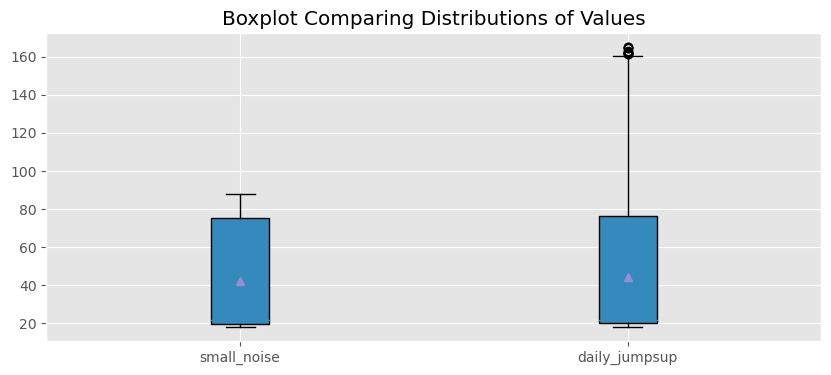

In [291]:
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))
# Use pyplot to plot the boxplots for each dataframe on the same axis.
plt.boxplot([df_small_noise['value'], df_daily_jumpsup['value']],
            labels=['small_noise', 'daily_jumpsup'],
            showmeans=True, patch_artist=True)
plt.title('Boxplot Comparing Distributions of Values');

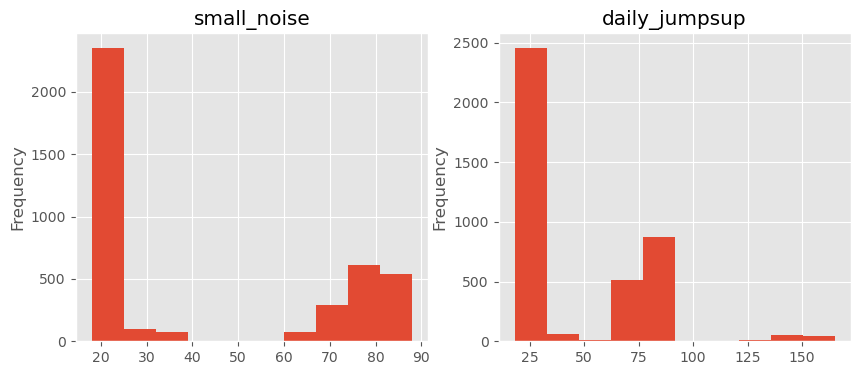

In [292]:
# Plot distributions of both data sets in subplots.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Plot the distribution of values for the small_noise data frame.
df_small_noise['value'].plot(kind='hist', ax=ax1, title='small_noise')

# Plot the distribution of values for the daily_jumpsup data frame.
df_daily_jumpsup['value'].plot(kind='hist', ax=ax2, title='daily_jumpsup');


<p style="color: #001a79;"> It is eveident that we are dealing with multi-modal data in both data sets. Neither are normal. However, since we have less than 5000 data points in each data set we can use the Shapiro-Wilk test to prove or disprove the hypothesis.<br><br>
The null hypothesis for the Shapiro-Wilk test is that the data is normally distributed. We will set a significance level of 0.05 meaning, if the returned p-value from the Shapiro-Wilk test is less than 0.05 we will reject the null hypothesis and conclude that the data is not normally distributed</p>


In [293]:
# Importing the Shapiro-Wilk test from scipy.stats.
from scipy.stats import shapiro

# Run Shapiro-Wilk test on small_noise data frame.
stat, p = shapiro(df_small_noise['value'])
print(f'Statistic = {stat:.3f}, p = {p:.3f}')

Statistic = 0.712, p = 0.000


In [294]:
# Run Shapiro-Wilk test on daily_jumpsup data frame.
stat, p = shapiro(df_daily_jumpsup['value'])
print(f'Statistic = {stat:.3f}, p = {p:.3f}')


Statistic = 0.737, p = 0.000


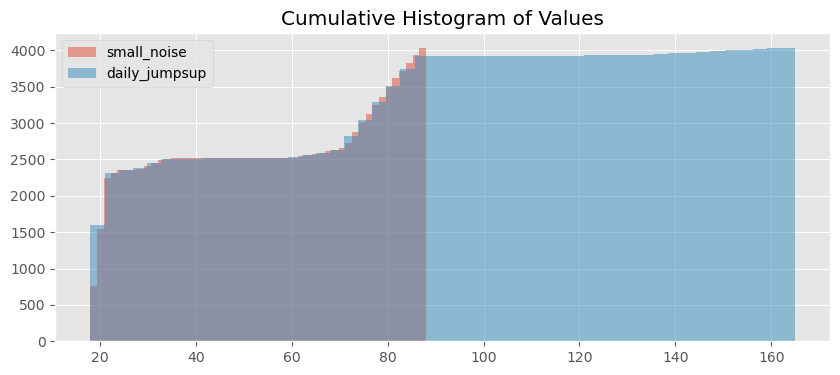

In [295]:
# Plot overlaid histograms of each data set
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))
# Use pandas to plot overlaid histograms for each dataframe on the same axis.
df_small_noise['value'].hist(bins=50, alpha=0.5, label='small_noise', cumulative=True)
df_daily_jumpsup['value'].hist(bins=50, alpha=0.5, label='daily_jumpsup', cumulative=True)
# Add a legend to the plot.
plt.legend(loc='upper left')
# Add a title to the plot.
plt.title('Cumulative Histogram of Values');


<p style="color: #001a79;"> Both the boxplot and cumulative histogram plot above indicate that the daily_jumpsup dataframe has more outliers than the small_noise dataframe.<br>
Since we are dealing with data which doesn't adhere to the normal distribution we can use the interquartile range method to determine if a point is "statisitically" an outlier or not.<br><br>
From Wikipedia:<br><br></p>

> The interquartile range is often used to find outliers in data. Outliers here are defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR.
 


In [296]:
def find_outliers_IQR(df):
    """Find outliers in a dataframe using the interquartile range.
    Args:
        df: Pandas dataframe.
        
    Returns:
        A list of the outliers.
    """
    # Get the first and third quartiles.
    q1, q3 = np.percentile(df, [25, 75])
    # Calculate the interquartile range.
    iqr = q3 - q1
    # Calculate the lower bound.
    lower_bound = q1 - (1.5 * iqr)
    # Calculate the upper bound.
    upper_bound = q3 + (1.5 * iqr)
    # Return a list of outliers.
    return df[(df < lower_bound) | (df > upper_bound)].index.tolist()

In [297]:
# Find outliers in the small_noise data frame using function above.
outliers = find_outliers_IQR(df_small_noise['value'])
# Print count of outliers
print(f'There are {len(outliers)} outliers in the small_noise data frame.')

There are 0 outliers in the small_noise data frame.


In [298]:
# Find outliers in the daily_jumpsup data frame using function above.
outliers = find_outliers_IQR(df_daily_jumpsup['value'])
# Print count of outliers
print(f'There are {len(outliers)} outliers in the daily_jumpsup data frame.')

There are 12 outliers in the daily_jumpsup data frame.


<p style="color: #001a79;"> Our outlier detection function has determined that there are 0 "statistical" outliers in the small_noise data set and 12 in the daily_jumpsup data set.<br>
Using a simple time series plot and overlaying the two data sets shows this quite easily (below)</p>

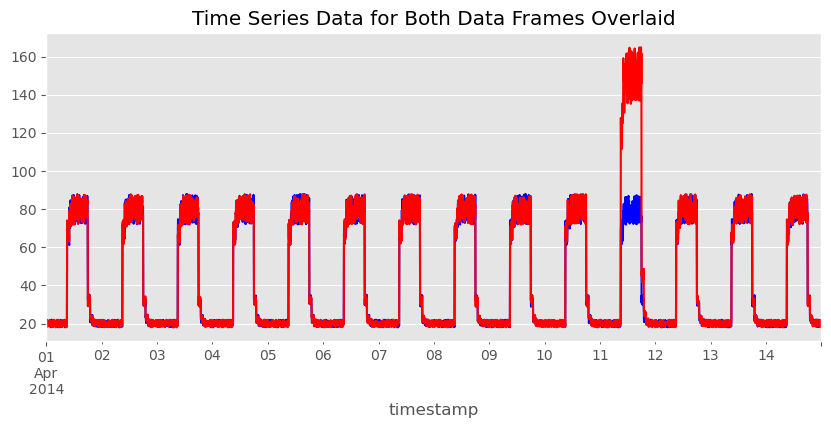

In [299]:
# Create time series data for both data frames overlaid (use dots).
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))
# Use pandas to plot overlaid time series data for each dataframe on the same axis.
df_small_noise['value'].plot(legend=False, ax=ax, color='blue')
df_daily_jumpsup['value'].plot(legend=False, ax=ax, color='red')
# Add a title to the plot.
plt.title('Time Series Data for Both Data Frames Overlaid');


<p style="color: #001a79;"> Now we have a slightly better understanding of our data. We know that there are no missing values present in either data set. Neither data set is normally distributed. We have outliers in the daily_jumpsup data set but not in the small_noise data set. Our goal is to accurately detect these anomalies.<br><br>
My next question would be: <b>Should we use Machine Learning?</b><br><br>
I know that the entire reason for this project is to deploy the Keras Anomaly Detection using Autoencoders but, to paraphrase Matthew Carbone in his article <a href="https://link.springer.com/article/10.1557/s43577-022-00417-z">When not to use machine learning: A perspective on potential and limitations</a>: Machine Learning is the Jack Hammer of the Data world and can do some incredible things. However you wouldn't use a jack hammer to do brain surgery and there are some problems for which Machine Learning is either unsuited or simply overkill.<br><br>
Let's consider the data once again. We can see that both data sets have the same patterns. There are troughs and peaks separated by a fairly rapid transition between each state. Using the highly technical skill of "eyeballing a chart" we could estimate that the trough for each dataset is between 0 and 40 (consistently) and the peak is typically around around 80 +/-20 (asides from the anomaly period).</p>

In [300]:
# Create a dataframe from daily_jumpsup with
# values between 70 and 170.
df_daily_jumpsup_high = df_daily_jumpsup[(df_daily_jumpsup['value'] > 70) & (df_daily_jumpsup['value'] < 170)]

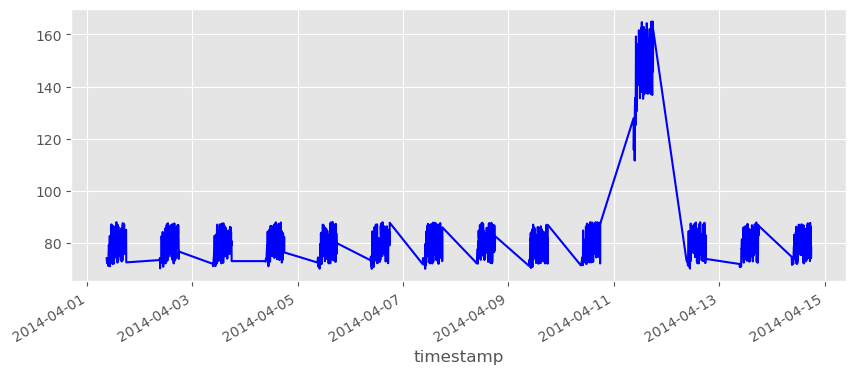

In [301]:
# plot the data
# Define the size of the figure.
fig, ax = plt.subplots(figsize=(10,4))
# Use pandas to plot df_daily_jumpsup_high.
df_daily_jumpsup_high.plot(legend=False, ax=ax, color='blue');



<h2 style="color: #001a79;">When All You Have is a Hammer - Everything Looks Like a Nail</h2>
<p style="color: #001a79;">Now that we have extracted the "peak" part of our data set (including the anomaly) we can consider how we might detect the anomaly (otherwise known as a "Assignable Cause Variation in SPC parlance) without using Machine Learning.<br><br>
The goal in Statistical Process Control is only to react to assignable cause variation. In essence there are two types of variation we see in processes:<br><br>
- Common Cause Variation: Inherent in the system and can only typically be improved by improving the equipment or changing procedures.<br>
- Assignable Cause Variation: Comes from sources outside the system e.g. Equipment malfunction, raw material problems, operator error etc.<br></p>

<p style="color: #001a79;">As we are dealing with continuous data that is not subgrouped we can use an I-MR (Individual - Moving Range) SPC chart to detect Assignable Cause Variation. The I-MR chart is a simple chart that plots the difference between the current value and the previous value. If the difference is greater than a pre-defined limit then the point is considered an "outlier" and is plotted on the chart.</p>

<p style="color: #001a79;">There are specific rules that should be considered when deciding if an I-MR chart is applicable:<br><br>
- The data should be continuous and not subgrouped.<br>
- The data should be in time order.<br>
- The data should be collected at appropriate intervals.<br>
- The data should be individual observations and not averages.<br>
- The data should include at least 100 observations.<br>
- The data should not be heavily skewed.<br>
- The observations should be independent of each other.<br><br>
Reference: <a href="https://support.minitab.com/en-us/minitab/21/help-and-how-to/quality-and-process-improvement/control-charts/how-to/variables-charts-for-individuals/i-mr-chart/before-you-start/data-considerations/">Data considerations for I-MR Chart</a>

</p>

<hr style="border-top: 1px solid #001a79;" />

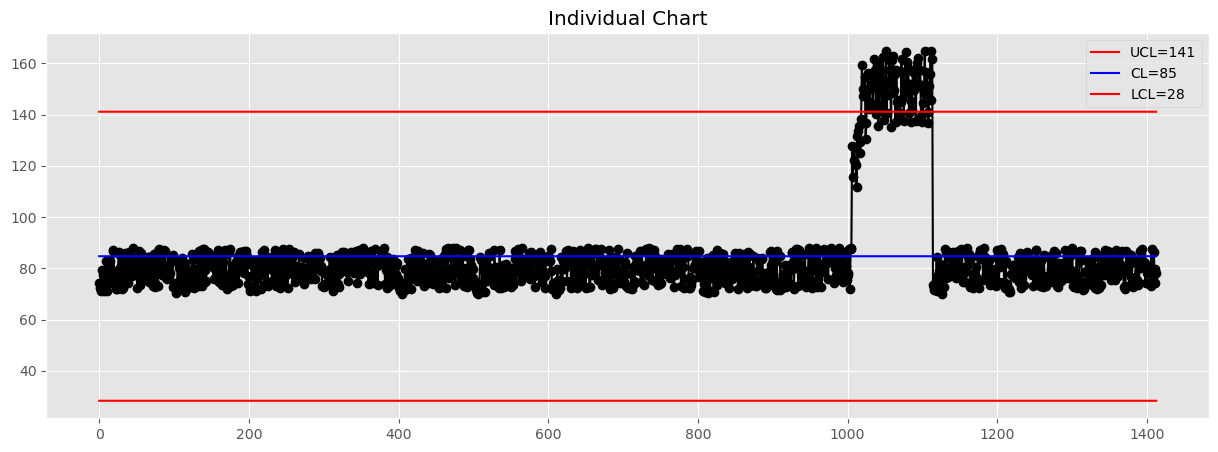

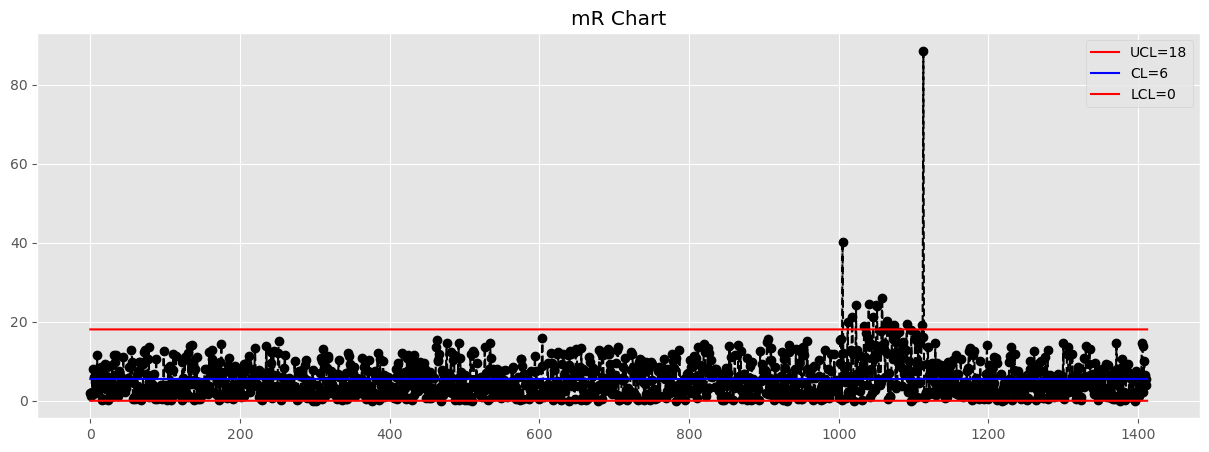

In [302]:
# Code adapted from: https://towardsdatascience.com/push-your-sales-with-statistical-process-control-52321f329405 

class SPC:
    def fit(self,data):
        self.X = data
        # Calculate the number of samples
        self.number_of_sample = len(self.X)
        # Create an array to store the moving range
        self.mR = np.zeros(((self.number_of_sample-1),1))
        # Calculate the moving range length
        for i in range(len(self.mR)):
            self.mR[i] = abs(self.X[i+1] - self.X[i])
    # Function to plot the Individual Bar and Moving Range chart (I / MR)
    def QCC(self):
        # Calculate the upper control limit for Individual Chart (Mean + 3 x standard deviation) 
        ucl_X = self.X.mean() + (3*self.X.std())
        # Calculate the central line for Individual Bar (mean)
        cl_X = self.X.mean()
        # Calculate the lower control limit for Individual Chart (Mean - 3 x standard deviation) 
        lcl_X = self.X.mean() - (3*self.X.std())
        # Calculate the upper control limit for Moving Range
        ucl_mR = 3.267*self.mR.mean()
        # Calculate the central line for Moving Range
        cl_mR = self.mR.mean()
        # Calculate the lower control limit for Moving Range 
        lcl_mR = 1-3*0.853/1.128 if 1-3*0.853/1.128 > 0 else 0

        
        # Plot Individual Bar chart (Chart includes LCL, Mean and UCL)
        plt.figure(figsize=(15,5))
        plt.plot(self.X,marker="o",color="k") 
        plt.plot([ucl_X]*len(self.X),color="r",label="UCL={:,.0f}".format(ucl_X)) 
        plt.plot([cl_X]*len(self.X),color="b",label="CL={:,.0f}".format(cl_X))
        plt.plot([lcl_X]*len(self.X),color="r",label="LCL={:,.0f}".format(lcl_X))
        plt.title("Individual Chart")
        plt.legend()
        plt.show()

        # Plot Moving Range chart (Chart includes LCL, Centre line and UCL)
        plt.figure(figsize=(15,5))
        plt.plot(self.mR ,marker="o",color="k", linestyle='--') 
        plt.plot([ucl_mR ]*len(self.X),color="r",label="UCL={:,.0f}".format(ucl_mR))
        plt.plot([cl_mR ]*len(self.X),color="b",label="CL={:,.0f}".format(cl_mR))
        plt.plot([lcl_mR ]*len(self.X),color="r",label="LCL={:,.0f}".format(round(lcl_mR,0)))
        plt.title("mR Chart")
        plt.legend()
        plt.show()

plt.style.use('seaborn-colorblind')
# Create an instance of the SPC class      
chart = SPC()
# Fit the daily_jumpsup_high data to the chart
chart.fit(df_daily_jumpsup_high['value'].to_numpy())
# Plot the X Bar and Moving Range chart
chart.QCC() 



<p style="color: #001a79;">Clearly we can detect assignable cause variation (anomalies) using the tried and tested method of Statistical Process Control. We could make the UCL and LCL limits more sensitive (In our example above I used the entire daily_jumpsup_high data set to calculate the limits) which would result in the first anomalous point breaching the upper control limit.<br><br>
One drawback of this approach is that we would essentially need two SPC charts. One monitoring the Peak data and the other monitoring the trough data. As this is a relatively simple signal it would be acceptable. However, with more complex signals this approach would become very cumbersome.<br><br>
What I like about SPC in general is that it is very easy to explain to upper management. Everyone can understand trends and outliers when presented in this method. If necessary I could elaborate on the calculations behind establishing the upper and lower control limits.<br><br>
With Machine Learning and, in particular, Neural Networks I doubt I could explain their workings to my management team!</p>

<hr style="border-top: 1px solid #001a79;" />

<h2 style="color: #001a79;">Preprocessing</h2>
<p style="color: #001a79;">Having illustrated that the anomalies in this particular data set could be detected using SPC and that Machine Learning is not necessarily required for this job, we will proceed with developing a Neural Network!<br><br> </p>

<p style="color: #001a79;">Preprocessing is a critical step in any Machine Learning project. The data must be in a format that the model can understand. We have already determined that there is no missing data in the data sets and there is one single feature: value. Had their been missing data we would have had to decide whether we want to delete all these entries (problematic since it is a time based measurement) or impute the missing data.<br><br>
The second preprocessing technique to consider is data normalization. There are several methods that we could chose from such as:<br><br>
- Min-Max Scaling<br>
- Standardization<br>
- Normalization<br> </p>

<p style="color: #001a79;">In this case we will use Z-score Normalization. This is a simple method that scales the data between based on the mean and standard deviation of the data. The formula is:<br><br></p>

$z = (x - u) / s $
<br><br>

<p style="color: #001a79;">Where:</p><br>

$x$ = value<br>
$u$ = mean<br>
$s$ = standard deviation<br><br>

</p>

<p style="color: #001a79;">The documentation doesn't delve in to why they decided to use Z-Score Normalization and persoannly I would have preferred Min-Max Scaling simply due to the fact that it is more intuitive and easier explained.</p>

<p style="color: #001a79;">Scaling is of particular importance when there are many attributes in the data set with different scales. For example, if we had a data set with the following attributes:<br><br>
- Age (0-20)<br>
- Height (0-2m)<br>
- Weight (0-200kg)<br><br>

</p>


<p style="color: #001a79;">The neural network would be heavily influenced by the weight attribute resulting in the neural network being biased towards it (also known as the <a href="https://en.wikipedia.org/wiki/Curse_of_dimensionality">Curse of Dimensionality)</a>.<br><br>
</p>


<hr style="border-top: 1px solid #001a79;" />

In [303]:
# Calculate the mean of the small_noise data frame.
train_mean = df_small_noise.mean()
# Print only the mean of the small_noise data frame.
print(f'The mean of the small_noise data frame is {train_mean[0]}.')

The mean of the small_noise data frame is 42.438353335806646.


In [304]:
# Calculate the standard deviation of the small_noise data frame.
train_std = df_small_noise.std()

print(f'Standard deviation of the small_noise data frame: {train_std[0]}')

Standard deviation of the small_noise data frame: 28.077122281262515


In [305]:
# Divide mean of small_noise data frame by standard deviation to scale data.
# This is known as Z-score normalization.
df_train_vals = (df_small_noise - train_mean) / train_std

In [306]:
# Check the first 5 rows of the scaled data frame.
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858828570643756
2014-04-01 00:05:00,-0.728993019611064
2014-04-01 00:10:00,-0.848147722033422
2014-04-01 00:15:00,-0.729585787129518
2014-04-01 00:20:00,-0.731172995574656


In [307]:
# min of the scaled data frame
train_min = df_train_vals.min()
# max of the scaled data frame
train_max = df_train_vals.max()

# Print the min and max of the scaled data frame.
print(f'The min of the scaled data frame is {train_min[0]} and the max is {train_max[0]}.')

The min of the scaled data frame is -0.8703665949916501 and the max is 1.6218818486602287.


In [308]:
# Create a scaled data frame using Min-Max scaling.
df_train_vals_min_max = (df_small_noise - df_small_noise.min()) / (df_small_noise.max() - df_small_noise.min())

<p style="color: #001a79;">Below we can see the impact of the two different scaling techniques compared to the top chart which shows the original small_noise data.<br>
Scaling maintains the shape of the data set but changes the scale. In the Z-Score Normalized data, we now have points ranging from ~-0.87 to ~ 1.62. This means that the lowest value is -0.87 standard deviations from the mean of 0 and the maximum value is +1.62 standard deviations from the mean of 0.<br><br>
With the Min-Max scaler all values from the small_noise data set are now between 0 and 1. To me, this is much easier to explain!<br><br>

</p>

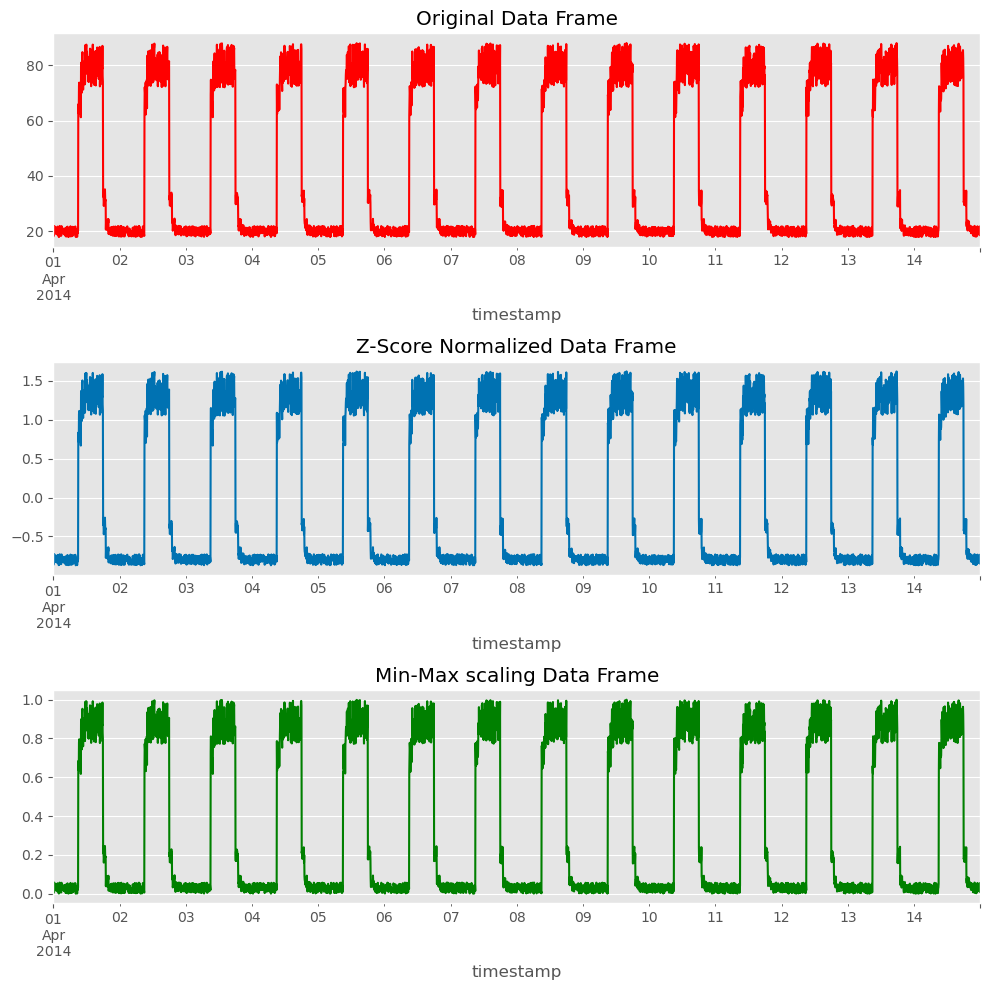

In [309]:
# Create a figure with three subplots.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
# plot the original data frame in the first subplot in red.
df_small_noise.plot(legend=False, ax=ax1, color='red')
# plot the Z-Score scaled data frame in the second subplot.
df_train_vals.plot(legend=False, ax=ax2)
# plot the scaled data frame using Min-Max scaling in the third subplot.
df_train_vals_min_max.plot(legend=False, ax=ax3, color='green')
# Add ax1 title Original Data Frame.
ax1.set_title('Original Data Frame')
# Add ax2 title Scaled Data Frame.
ax2.set_title('Z-Score Normalized Data Frame')
# Add ax3 title Scaled Data Frame using Min-Max scaling.
ax3.set_title('Min-Max scaling Data Frame')
# increase space between subplots.
fig.tight_layout();


In [310]:
# Check the number of training samples and shape of array
df_train_vals.shape

(4032, 1)

In [311]:
# Check the columns included in the training data frame. 
df_train_vals.columns

Index(['value'], dtype='object')

<h3 style="color: #001a79;">Window Size Explained</h2>

<p style="color: #001a79;">If we had the following sequence of data:</p>

```python
[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
```

<p style="color: #001a79;">And we created a window size of 3 we would get the following:</p>

```python
window_size = 3
[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]
```
</p>
<br>

<p style="color: #001a79;">
Note above - The windows are not dynamic, in other words, each window must have the specified number of elements (in our example 3)<br>
The number of windows possible from an array of size x would be defined as:

$ length(x) - window\_size + 1 $

$ = 12 - 3 + 1 $

$ = 10 $

<br>
</p>
<p style="color: #001a79;">The data we are working with is collected at regular intervals. There is one value recorded every 5 minutes throughout the day over a 14 day period.<br>
This results in 288 samples taken over a 24 hour period:</p><br>

$ 24 * 60 / 5 = 288 $ 

<br>
<p style="color: #001a79;">Calculating the number of windows possible from the small_noise data set:</p>

$ length(small\_noise) - window\_size + 1 $

$ = 4032 - 288 + 1 $

$ = 3745 $

<br>

<p style="color: #001a79;">The window size is the number of samples that are used to predict the next sample. In our training data we are using 288 samples to predict the next sample.<br> The input data to our model is the change in value from the previous 288 time steps, giving us 288 individual input features. <a href="https://medium.com/mindboard/training-recurrent-neural-networks-on-long-sequences-b7a3f2079d49">Reference</a></p>

In [312]:
# Defining window size based on number of measurements per day.
window_size = 288

In [313]:
# Generating training sequences for use in the model.
def windows(vals, N=window_size):
  # Define an empty list (L) to store the sequences.
  L = []
  # Loop through the data frame and create sequences of length N (windows).
  for i in range(len(vals) - N + 1):
    # Append a window to the list.
    L.append(vals[i:i+N])
  # Stack the sequences (windows) in a numpy array.
  return np.stack(L)

In [314]:
# Create windows from the training data frame.
x_train = windows(df_train_vals)

In [315]:
'''
# This code block creates and saves a Matplotlib Animation
# to illustrate windows. It takes ~ 1 min 10 secs to run.
# I have commented out the code so it doesn't exdcute every time you run the notebook.
# The resulting animation is shown in the markdown cell below.

# Reference: https://matplotlib.org/stable/api/animation_api.html

# Package for creating animations using matplotlib.
import matplotlib.animation as animation


# Create the figure and axis
fig, ax = plt.subplots(figsize=(10,4))

# Define a function that will update the plot for each frame of the animation
def update(num):
    start = num
    end = start + 288
    data = df_train_vals['value'][start:]  # Select all the data after the start index
    
    # Clear the text labels from the plot (otherwise they overlap)
    for t in ax.texts:
        t.set_visible(False)
    
    # Plot the data in black, except for the window data which will be plotted in red
    ax.plot(data[:end], color='black')
    ax.plot(data[start:end], color='red')
    
    # Remove the x-axis labels
    ax.xaxis.set_ticklabels([])

    # Add a text label showing the current window number
    ax.text(0.5, 1.0, f'Window {num + 1}', transform=ax.transAxes, ha='center')

# Create the animation using the Matplotlib FuncAnimation function
ani = animation.FuncAnimation(fig, update, frames=200, interval=100)

# Save the Plot as a 'images\animation.gifgif.
ani.save(', writer='imagemagick')

# Prevent final window showing in ouput cell
# (reference:https://stackoverflow.com/questions/18717877/prevent-plot-from-showing-in-jupyter-notebook )
plt.close()

'''

"\n# This code block creates and saves a Matplotlib Animation\n# to illustrate windows. It takes ~ 1 min 10 secs to run.\n# I have commented out the code so it doesn't exdcute every time you run the notebook.\n# The resulting animation is shown in the markdown cell below.\n\n# Reference: https://matplotlib.org/stable/api/animation_api.html\n\n# Package for creating animations using matplotlib.\nimport matplotlib.animation as animation\n\n\n# Create the figure and axis\nfig, ax = plt.subplots(figsize=(10,4))\n\n# Define a function that will update the plot for each frame of the animation\ndef update(num):\n    start = num\n    end = start + 288\n    data = df_train_vals['value'][start:]  # Select all the data after the start index\n    \n    # Clear the text labels from the plot (otherwise they overlap)\n    for t in ax.texts:\n        t.set_visible(False)\n    \n    # Plot the data in black, except for the window data which will be plotted in red\n    ax.plot(data[:end], color='black')

<p style="color: #001a79;">The animation below shows how our window of size 288 iterates over the data moving one step at a time.<br>
Here we are showing the transitions of the first 200 windows.</p> <br><br>

<img src="images/animation.gif" align="center"> 


In [316]:
# Print out length of first window.
print(len(x_train[0]))


288


In [317]:
# Check the first and last values of the first window.
x_train[0][0], x_train[0][-1]

(array([-0.85882857]), array([-0.79671155]))

In [318]:
# Print out the shape of the training data.
# Verify window size and number of windows match our expectations.
print(f'The training data has {x_train.shape[0]} windows of {x_train.shape[1]} measurements each.')


The training data has 3745 windows of 288 measurements each.


<h2 style="color: #001a79;">Neural Network</h2>
<p style="color: #001a79;">Now that we have preprocessed our training data we can proceed to creating our Neural Network for Anomaly Detection<br> </p>
<h3 style="color: #001a79;">Definitions</h3>
<p style="color: #001a79;">
- <b>Input Layer</b>: <br><br>
We use the input layer to define a tensor for the first layer of the Neural Network.<br>
A tensor is a generalization of vectors and matrices to potentially higher dimensions.<br>
"In the general case, an array of numbers arranged on a regular grid with a variable number of axes is known as a tensor." (Goodfellow, I., Bengio, Y., Courville, A. (2016)) <br>
</p>
<p style="color: #001a79;">
When we define our input layer we are defining the shape of the tensor. In our case we are using a 2D tensor with the shape (288, 1).<br>
Becasue we are creating a sequential model, Keras can automatically infer the shape of the next layer based on the shape of the previous layer. This is why it is essential to get your input layer correct.<br><br>
</p>

<p style="color: #001a79;">
- <b>Conv1D Layer</b>: <br><br>
With normal dense Neural Networks, every node in one layer is connected to every node in the next layer. This is not the case with Convolutional Neural Networks. In a Convolutional Neural Network, each node in one layer is only connected to a small number of nodes in the next layer. <br>
A convolution in our example is a mathematical operation that essentially "smooths" the time series data. <br>
<br>
<br>
The GIF below available at: <a href="https://jinglescode.github.io/2020/11/01/how-convolutional-layers-work-deep-learning-neural-networks/">Jingles Code Github Page</a> shows how a Convolutional layer with a kernel size of 3 works. <br><br>


<img src="images/conv2-.gif" align="center">

<br><br>
</p>

<p style="color: #001a79;">
Since we are dealing with a time series data set we use a one-dimensional convolutional layer. This is because we are dealing with a single feature (value) over time. <br>
First we specify the number of <b>filters</b>. This is essentially the number of different windows of "kernel_size" we will have.<br>
The <b>kernel size</b> is the size of the sequential window of the input. When we specify a kernel size of 7 we mean that 7 input nodes are operated one at a time passing the result to the next layer. <a href="https://www.databricks.com/glossary/convolutional-layer">Reference</a><br>
Having filters = 32 and kernel_size = 7 means that we are creating 32 different filters each of size (length) 7. <br>
I found it hard to visualise this aspect but found this diagram (adapted from <a href="https://www.researchgate.net/publication/344229502_A_Novel_Deep_Learning_Model_for_the_Detection_and_Identification_of_Rolling_Element-Bearing_Faults">A Novel Deep Learning Model for the Detection and Identification of Rolling Element-Bearing Faults</a>) useful :<br><br><br>
</p>

<img src="images/conv1d.png" alt="1D convolution layer" style="width: 800px;"/>

<br><br>
<p style="color: #001a79;"><b>Padding</b> is used to ensure that the output of the convolutional layer has the same shape as the input. This is done by adding zeros to the input. <br>
Consider the first GIF above, we can see that an input vector of size 6 and kernel size of 3 results in an output vector of size 4. The output has been reshaped.<br>
If we wanted to maintain the same shape we would add zeros to the input vector. This is what padding does. Image courtesy of <a href="https://jinglescode.github.io/2020/11/01/how-convolutional-layers-work-deep-learning-neural-networks/">JinglesCode</a> <br><br>
</p>


<img src="images/padding.gif" align="center">


<br><br>
<p style="color: #001a79;">
<b>Strides</b> is the number of steps the kernel takes when moving across the input. In all the examples we looked at above, the stride was 1. This means that the kernel moved one step at a time. <br><br>
The last parameter we need to specify is the <b>activation</b> function. An activation function is a function used in Neural networks which "outputs a small value for a small input and a large value for a large input. If the inputs are large enough the activation functions "fires" otherwise, it does nothing" (Wood (Date Unknown))<br><br>
The <b>Rectified Linear Unit (ReLU)</b> is described as one of the simplest activation functions. If the function receives any negative input it will return 0, otherwise it will return the input value. <a href="https://deepchecks.com/glossary/rectified-linear-unit-relu/#:~:text=ReLU%20formula%20is%20%3A%20f(x,range%20of%200%20to%20infinite.">Reference</a><br>
</p>


<p style="color: #001a79;"> The ReLU Formula is:

 $ f(x) = max(0, x) $

</p>
<br>
<br>
<p style="color: #001a79;">
- <b>Drop Out Layer</b>: <br><br>
The Keras Documentation describes the Dropout layer as:
"The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.<br>
 Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged." <a href="https://keras.io/api/layers/regularization_layers/dropout/">Dropout Layer Documentation</a><br>
</p>
<p style="color: #001a79;">
Put simply, the drop out layer randomly sets a percentage of the input units to 0. This helps prevent overfitting allowing your model to perform more robustly on held-out test data. <br><br>
</p>
<p style="color: #001a79;"><b>- Conv1DTranspose layer:</b><br><br>
The Conv1DTranspose layer is the inverse of the Conv1D layer in spatial terms. It is wrong to think of this step as a "deconvolution" - we are not reversing the operations of the convolution layers but rather, we are reducing the dimensionality imposed by the convolutions back to the same shape as the original input. (<a href = "https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11">Reference</a>)<br><br>
To better visualise this, we can look at the diagram below.(adapted from <a href="https://www.researchgate.net/publication/344229502_A_Novel_Deep_Learning_Model_for_the_Detection_and_Identification_of_Rolling_Element-Bearing_Faults">A Novel Deep Learning Model for the Detection and Identification of Rolling Element-Bearing Faults</a>).<br><br><br>

<img src="images/transpose.svg" alt="Conv1DTranspose" align="center" style="width: 1200px;"/>

<br><br></p>

<p style="color: #001a79;">
You'll notice that the filters applied in each subsequent Conv1DTranspose layer are in the exact opposite order to the Conv1D layers until, finally, we have a layer with a filter of size 1. </p>
<br><br>


In [319]:
# Creating a sequential model.
layers = [
  # Input layer to define the shape of the input data.
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  # First Convolutional Layer.
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Drop Out Layer with 20% of the data randomly dropped.
  keras.layers.Dropout(rate=0.2),
  # 2nd Convolutional Layer.
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # 1st Deconvolutional Layer.
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Drop Out Layer with 20% of the data randomly dropped.
  keras.layers.Dropout(rate=0.2),
  # 2nd Deconvolutional Layer.
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Final Deconvolutional Layer this returns the original shape of the data.
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

<p style="color: #001a79;"> If you are getting a Kernel error when running the code, and the Kernel keeps crashing at this point despite restarting, you may need to intall <code>nomkl</code> as I did.<br><br>
In your Anaconda Prompt, type the following command: <code>conda install -c conda-forge nomkl</code><br><br></p>

<p style="color: #001a79;">
<code>mkl</code> is a library for Intel and compatible processors but there have been documented issues with it and Tensorflow. <a href="https://stackoverflow.com/questions/59576397/python-kernel-dies-on-jupyter-notebook-with-tensorflow-2">Stack Overflow Reference</a><br><br>
 </p>

In [320]:
# Create model based on the layers defined above.
model = keras.Sequential(layers)

<h3 style="color: #001a79;">The Adam Optimizer</h2>

<p style="color: #001a79;">According to <a href="https://keras.io/api/optimizers/adam/">The Keras Documentation</a>:

> Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.According to Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".
</p>
<p style="color: #001a79;">Clear as mud to a beginner like me! So let's start with <b>stochastic gradient descent</b>.</p>

<p style="color: #001a79;">
For many machine learning algorithms the goal is to find the minimum (or maximum) of a function. This is done by calculating the gradient of the function and moving in the direction of the gradient. This is called gradient descent. In a simple linear regression problem you want to find a model that maps x to the predicted response <i>f(x)</i> so that <i>f(x)</i> is as close as possible to <i>y</i>. The goal here is to minimize the residuals between the prediction <i>f(x)</i> and the actual data <i>y</i>.<br><br>
If we are using Mean Squared Error as our loss function, the lower the value from our linear regression model, the more accurate our predictions are. A linear regression model would adjust the model parameters until the lowest MSE was obtained.</p>
<p style="color: #001a79;">Let's walk through an example of how this works. Gradient Descent works.<br><br>
First we create some data using <code>numpy.random.rand</code> Then we plot the data and calculate the best line fit using <code>numpy.polyfit</code>.</p><br><br>

<br><br>

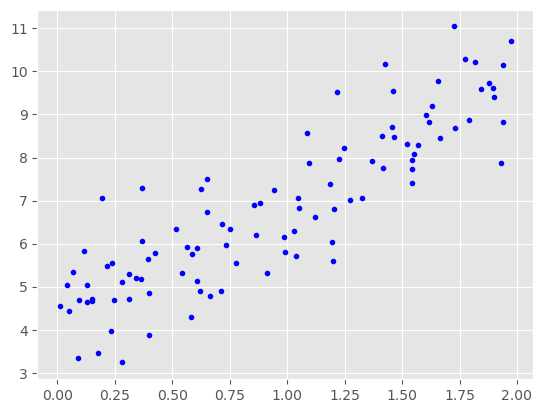

In [321]:
# Creating x and y data.
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

# Plot the data.
plt.plot(X, y, "b.");

In [322]:
# transform X and y into series to use np.polyfit
X_series = pd.Series(X.reshape(100,))
y_series = pd.Series(y.reshape(100,))

In [323]:
# Use numpy polyfit to create a linear model.
Linear_model = np.polyfit(X_series, y_series, 1)
Linear_model

array([2.77011339, 4.21509616])

<p style="color: #001a79;"> In our example above, <code>Numpy</code> has minimised the Mean Squared Error and calculated the best line fit for our data as:

$ y = 2.7771x + 4.2206 $ </p>

<p style="color: #001a79;"> Gradient Descent is a tool which enables a machine learning algroithm to arrive at the line of best fit. In simple terms, we start  with a random fitted line for the data then we change the parameters of the line (slope and y-intercept) until we arrive at the line of best fit. <br> Every time a line is tried we calculate the sum of the squares of the errors (SSE) and the line with the lowest SSE is the line of best fit. <br><br>
Now we will create our own gradient descent function to find the line of best fit for our data. We will use the same data as above. <br><br>
A great analogy for gradient descent is that of a mountaineer attempting to get to the bottom of a mountain. The only equipment she has is an altimeter. She starts to descend in a random direction and checks the reading from the altimeter, if the height reading is higher than the initial reading then she is going in the wrong direction and she turns around and tries again. After many iterations she will have reached the bottom of the mountain. <br><br>
In machine learning terminology: <br><br>
- Distance moved in any direction = Learning Rate <br>
- Altimeter reading = Cost Function <br>
- Direction of steps = Gradient <br><br>


In [324]:
# Reference: https://www.kaggle.com/code/penchalaiah123/step-by-step-guide-to-gradient-descent
# Create a function to calculate the cost.
# Note: Theta is the weights assigned to each feature.
def calc_cost(theta, X, y):
    # Number of training samples.
    m = len(y)
    # Calculate the predictions based on the current weights.
    predictions = X.dot(theta)
    # Calculate the cost.
    cost = (1/2*m) * np.sum(np.square(predictions-y))
    return cost

In [325]:
# Reference: https://www.kaggle.com/code/penchalaiah123/step-by-step-guide-to-gradient-descent
# Create a function to perform gradient descent.
def gradient_descent(X, y, theta, learning_rate, iterations):
    # number of training examples
    m = len(y)
    # history of cost values
    cost_history = np.zeros(iterations)
    # history of theta values
    theta_history = np.zeros((iterations, 2))
    # gradient descent loop
    for it in range(iterations):
        # Returns the dot product of two arrays (X and theta).
        prediction = np.dot(X, theta)
        # Note: X.T.dot computes the of preciction - y with its transpose X.T.
        theta = theta - (1/m) * learning_rate * ( X.T.dot((prediction - y)))
        # Save the cost value for each iteration. 
        theta_history[it, :] = theta.T
        cost_history[it]  = calc_cost(theta, X, y)
    return theta, cost_history, theta_history


<p style="color: #001a79;">So we now have two functions. the <code>calc_cost</code> function will calculate the cost function every time it is called. The <code>gradient_descent</code> function will calculate the gradient and move in the direction of the gradient until the cost function is minimised. We need to calculate two theta values (representing the slope and y-intercept) but to start off we need to supply two random values to the <code>gradient_descent</code> function from where it will begin.  <br><br>

In [326]:
# Set the learning rate (size of the steps)
lr = 0.01
# Set the number of iterations.
n_iter = 5000
# Set the initial weights.
theta = np.random.randn(2,1)

X_b = np.c_[np.ones((len(X), 1)), X]  # add x0 = 1 to each instance (np.c_ is a numpy function that concatenates arrays)
# Run the gradient descent function.
theta, cost_history, theta_history = gradient_descent(X_b, y, theta, lr, n_iter)

print(f'Final value of theta0: {theta[0][0]}')
print(f'Final value of theta1: {theta[1][0]}')
print(f'Final cost/MSE: {cost_history[-1]}')



Final value of theta0: 4.214746114641415
Final value of theta1: 2.7704224552973677
Final cost/MSE: 4032.923004866737


<p style="color: #001a79;">When we used <code>np.polyfit</code> to calculate our y-intercept and slope we got the values 2.77707263, 4.2206232
<br>
Using our gradient descent function we get the values 2.77719081, 4.22048404<br><br>
We can also look at how the loss function decreased over the number of iterations.</p>

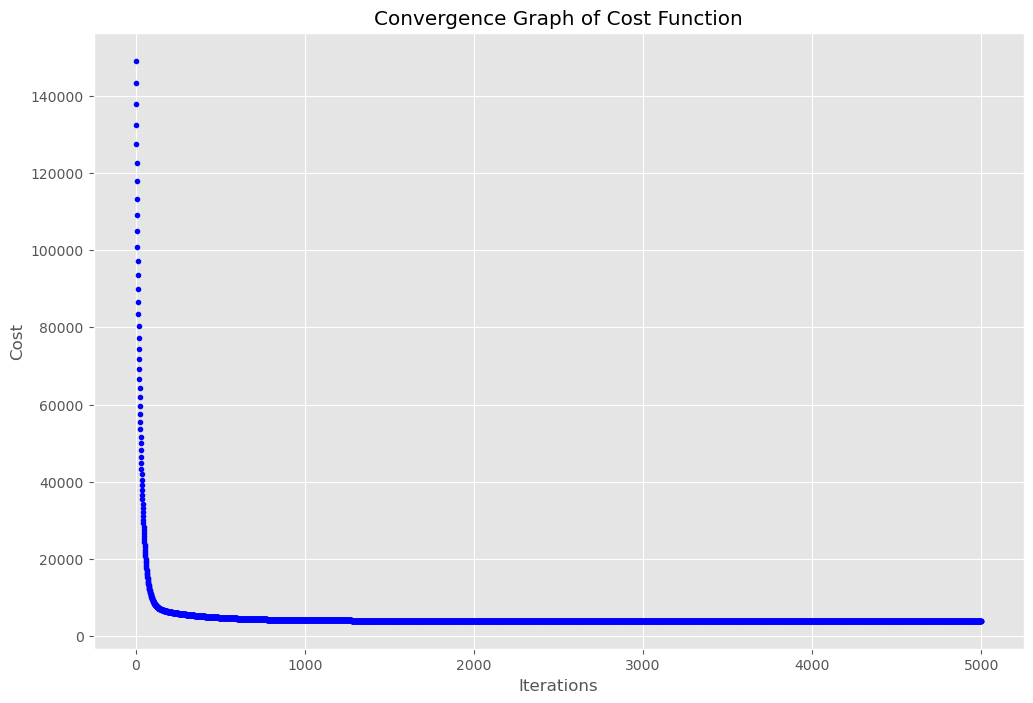

In [327]:
# Create a figure and axis.
fig,ax = plt.subplots(figsize=(12,8))

ax.plot(range(n_iter),cost_history,'b.')
# Add axis labels.
ax.set_ylabel('Cost')
ax.set_xlabel('Iterations')
# Add title.
plt.title("Convergence Graph of Cost Function");


<p style="color: #001a79;"><b>Impact of Different Learning Rates</b><br><br>
Learning rate is one of the most critical parameters in gradient descent. If the learning rate is too high, the gradient descent algorithm may overshoot the minimum. If the learning rate is too low, the gradient descent algorithm may take too long to converge or, indeed, never converge to the minimum. <br><br>
Consider the example below, with a learning rate of 0.001 and only 500 iterations we have not reached the minimum. However, a learning rate of 0.01 in this example does converge <br><br>

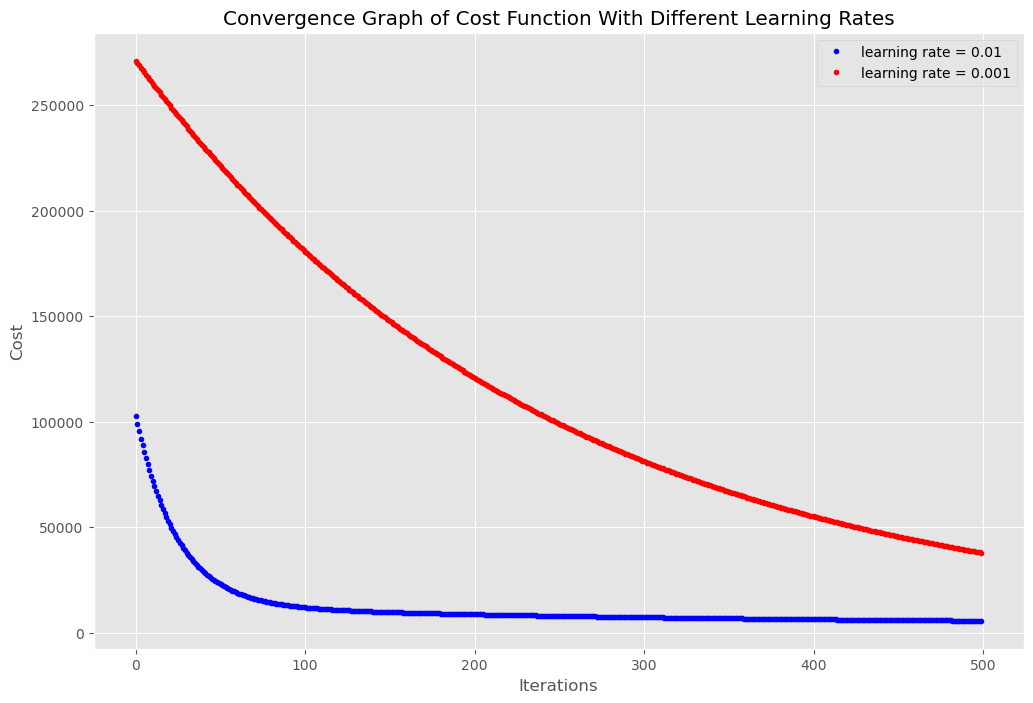

In [328]:
# Set the initial weights.
theta = np.random.randn(2,1)

# Call the gradient descent function with learning rate set to 0.01.
theta, cost_history, theta_history = gradient_descent(X_b, y, theta, 0.01, 500)

# Reset the initial weights.
theta = np.random.randn(2,1)

# Call the gradient descent function with learning rate set to 0.001.
theta_1, cost_history_1, theta_history_1 = gradient_descent(X_b, y, theta, 0.001, 500)


# plot both cost histories on same graph
fig,ax = plt.subplots(figsize=(12,8))

ax.plot(range(500),cost_history,'b.', label='learning rate = 0.01')
ax.plot(range(500),cost_history_1,'r.', label='learning rate = 0.001')
# Add axis labels.
ax.set_ylabel('Cost')
ax.set_xlabel('Iterations')
# Add title.
plt.title("Convergence Graph of Cost Function With Different Learning Rates")
# Add legend.
plt.legend();


<p style="color: #001a79;">
<b>Stochastic gradient descent</b> algorithms are a modification of gradient descent. In stochastic gradient descent, you calculate the gradient using just a random small part of the observations instead of all of them. In some cases, this approach can reduce computation time.</p>
<p style="color: #001a79;">Finally we can discuss the <b>Adam Optimizer</b>. <br><br>
This optimizer is an extended version of stochastic gradient descent. <a href="https://optimization.cbe.cornell.edu/index.php?title=Adam">(Cornell University (2021))</a>. It was first introduced to the world at the International Conference on Learning Representations 2015. Where the traditional gradient descent (such as the example that we looked at above) maintains a single learning rate throughout training, Adam computes individual adaptive learning rates for different parameters <a href = "https://arxiv.org/abs/1412.6980">(Kingma, Ba (2014))</a>. What makes Adam different from other adaptive learning methods is that it uses the first and second moments of the gradients to adapt the learning rate. The first moment is the average mean of the gradient, the second moment is the uncentred variance of the gradients <a href = "https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/">(Brownless (2017))</a> </p>
<p style="color: #001a79;">In his course <i>CS231n: Convolutional Neural Networks for Visual Recognition</i> Stanford University's <a href="https://cs231n.github.io/">Andrej Karpathy</a> states:</p>

> In practice Adam is currently recommended as the default algorithm to use, and often works slightly better than RMSProp. However, it is often also worth trying SGD+Nesterov Momentum as an alternative.

In [329]:
# Create and Adam Optimizer with a learning rate of 0.001.
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [330]:
# Create the model using the Adam optimizer with Mean Squared Error as the loss function.
model.compile(optimizer=optimizer, loss="mse")

In [331]:
# Display a summary of the model we just created.
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_8 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_12 (Conv1D  (None, 144, 16)          1808      
 Transpose)                                                      
                                                                 
 dropout_9 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_13 (Conv1D  (None, 288, 32)          3616      
 Transpose)                                           

<p style="color: #001a79;">The model summary above gives us an idea of what is happening in each of our layers.</p>

<p style="color: #001a79;">
- The first layer (Conv1D) applied the relevant filters to the input layer and output 32 different channels of data of length 144. <br>
- The second layer (dropout) randomly drops 20% of the data to prevent overfitting but does not alter the output shape <br>
- The third layer (Conv1D) halves the number of channels to 16 and halves the length of the data to 72. This is due to the stride length of 2 <br>
- We then have our first transpose layer which "upsamples" the data by doubling the sequence length to 144.<br>
- The next layer is a dropout layer which randomly drops 20% of the data to prevent overfitting but does not alter the output shape <br>
- The second last layer is another transpose layer which "upsamples" the data by doubling the sequence length to 288 and the number of channels to 32. <br>
- The final transpose layer transposes the data back to the original shape of 288 x 1.</p><br><br>

<p style="color: #001a79;">The next step is to fit the model we have created to our data. You will notice that we use x_train twice in the fit function below.<br> Per the <a href="https://keras.io/examples/timeseries/timeseries_anomaly_detection/">Keras Documentation</a> <i>we are using x_train as both the input and the target since this is a reconstruction model.</i></p>

<p style="color: #001a79;">You'll note that we have defined a <code>batch_size</code> and an <code>epoch</code> parameter.<br>
An epoch is one pass through the neural network of all training samples.<br>
Batch_size refers to the number of training instances in one batch.<br>
Our training data consists of 3745 samples. We use 10% of this data for validation purposes resulting in an effective training set size of 3370.<br>  With a batch size of 128 we get a total of 26.33 batches (we round that up to 27).<br>
When we call the <code>mode.fit</code> function, the first batch (128 instances) are taken from the data set, processed through the model and the parameters are updated (i.e. one gradient update is performed).<br> The function then takes the second batch of 128 samples, trains the model and updates the parameters (a second gradient update).<br> This iterative approach will continue until all 27 batches have been processed. At this point we have concluded one epoch. <a href="https://rukshanpramoditha.medium.com/all-you-need-to-know-about-batch-size-epochs-and-training-steps-in-a-neural-network-f592e12cdb0a">(Pramoditha (2022))</a> </p>

<p style="color: #001a79;">Lastly we specify <i>EarlyStopping</i>. This stops the training cycle when a monitored metric (in our case MSE) stops improving over a period of time.<br> We set the <code>patience</code> parameter to 5. This means that if the MSE does not improve over 5 epochs the training cycle will stop.</p> 
<p style="color: #001a79;">One major aspect of any machine learning project that the documentation for Timeseries anomaly detection using an Autoencoder does not cover is how to tune the hyperparameters of the model. <br>
So far in this model we have seen several hyperparameters that have been given certain settings with no explanation. Kernel size, filters, strides, learning rate, epochs and batch_size are all extremely important model parameters yet, there is no reason given for why the values for these parameters were chosen.<br>
Keras does provide a comprehensive <a href="https://keras.io/guides/keras_tuner/getting_started/">Hyperparameter Tuner</a> which is beyond the scope of this project but would typically be used when creating your neural network to optimise each of the hyperparameters.<br><br>


In [332]:
# Reminding everyone of the shape of our training data.
x_train.shape

(3745, 288, 1)

In [333]:
# Fitting the baseline model to the data.
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 6s 204ms/step - loss: 0.5569 - val_loss: 0.1115
Epoch 2/50
27/27 [==============================] - 5s 187ms/step - loss: 0.0817 - val_loss: 0.0426
Epoch 3/50
27/27 [==============================] - 5s 166ms/step - loss: 0.0580 - val_loss: 0.0390
Epoch 4/50
27/27 [==============================] - 5s 178ms/step - loss: 0.0493 - val_loss: 0.0348
Epoch 5/50
27/27 [==============================] - 5s 174ms/step - loss: 0.0422 - val_loss: 0.0307
Epoch 6/50
27/27 [==============================] - 5s 170ms/step - loss: 0.0361 - val_loss: 0.0281
Epoch 7/50
27/27 [==============================] - 4s 166ms/step - loss: 0.0321 - val_loss: 0.0269
Epoch 8/50
27/27 [==============================] - 4s 154ms/step - loss: 0.0288 - val_loss: 0.0232
Epoch 9/50
27/27 [==============================] - 4s 159ms/step - loss: 0.0265 - val_loss: 0.0226
Epoch 10/50
27/27 [==============================] - 5s 176ms/step - loss: 0.0244 - val_loss: 0.0208

<h2 style="color: #001a79;">Evaluation</h2>
<p style="color: #001a79;">Training a machine learning model is one of several key steps in the machine learning life-cycle. Determining how the model performs on "unseen" data is also critical.<br>
When we evaluate our machine learning model we are measuring how well it generalises on future unseen data. </p>
<p style="color: #001a79;">There are two types of model evaluation techniques:

- Hold Out
- Cross Validation.
</p>

<p style="color: #001a79;">The method used in the example we are following is hold out.<br><br> We have a <b>Training Set</b> which is a subset of the data set used to train the model (in our case 90% of the samples).<br> A validation set is used to measure the performance of the model during the training (10% of the data set in our example).<br> And there is a <b>Test Set</b> which is used to evaluate the performance of the model after the training is complete (the daily_jumpsup dataframe in our example).<br>

<p style="color: #001a79;">First we will consider how the model performed on the validation set. We will then evaluate the model on the test set.</p>

<hr style="border-top: 1px solid #001a79;" />

In [334]:
# List the keys returned by the history object.
# history was created when we called the fit method on the model.
list(history.history.keys())

['loss', 'val_loss']

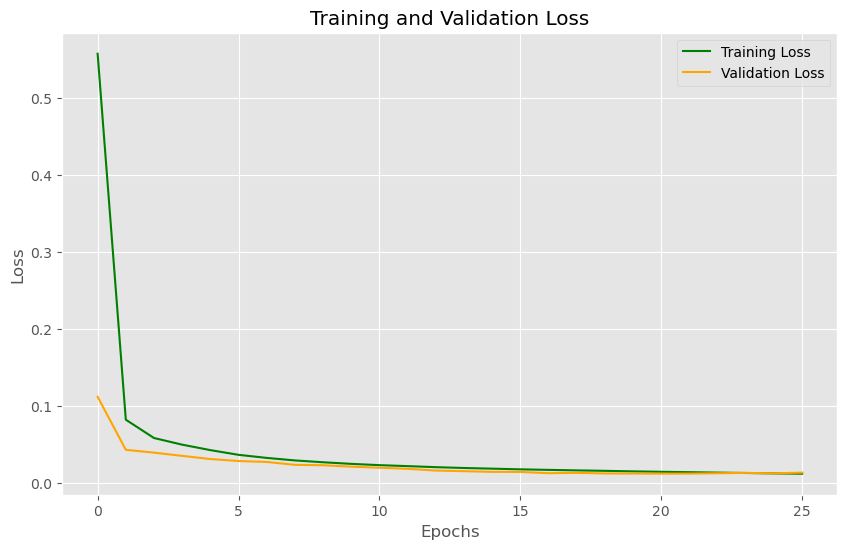

In [335]:
# Create a figure and axis.	
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the training loss over epochs
ax.plot(history.history["loss"], label="Training Loss", color="green")
# Plot the validation loss over epochs.
ax.plot(history.history["val_loss"], label="Validation Loss", color="orange")
# Add axis labels.
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
# Add a title.
ax.set_title("Training and Validation Loss")
# Display Legend
ax.legend();

<p style="color: #001a79;">The Keras gives us no indication of what the above chart represents or whether the model performance is good or bad!<br><br>
 The Learning Curve is a powerful tool that allows us to determine whether the model is <b>Underfitting</b>, <b>Overfitting</b> or <b>Generalising Well</b> when considering<br>the Loss function of the training data versus the loss function of the validation data over epochs.</p>

<p style="color: #001a79;">The shape of the learning curves can help to diagnose the behaviour of the machine learning model but you need to be aware that the loss function / gain function that your model is minimising / maximizing will have a huge impact on the expected curves.<br> The following examples have been adapted from <a href="https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/">Jason Brownlee (2019)</a></p>

<p style="color: #001a79;"> <b>Underfitting</b> - Refers to a model that cannot learn the training dataset. "...it occurs when the model is not able to obtain a sufficiently low error value on the training set" (Goodfellow, I., pg 110 (2016)). In an ideal scenario we want the training loss (when our model is minimizing MSE as in our example) to be small <b>and</b> we want the gap between the training and validation loss to be small also. This indicates that the model is generalising well. <br><br></p>

<p style="color: #001a79;">The following examples show some example curves for models that are underfitting.</p> <br><br>

<img src="images/underfit.png" alt="Examples of Model Underfitting" style="width: 1200px;"/>


<br><br>

<p style="color: #001a79;">The example on the left indicates that the model was unable to learn the training data set at all. You can see a flat line for loss on both the training and validation datasets.<br>The right hand image indicates that the model has been learning from the dataset but requires further training (increased epochs). Ideally we want to see both the training and validation loss level out and not be in a downward trajectory when the model has completed training.</p><br><br>

<p style="color: #001a79;"> <b>Overfitting</b> - Refers to a model that has learned the training set (including the random variation) too well. It has essentially memorized the training data but cannot then generalise on the validation data set. In the learning curve this will be apparent as either the gap between the training error and validation error will be too large or, you may see the training loss decrease with the number of epochs while the validation loss starts to increase.<br><br></p>

<p style="color: #001a79;">The following examples show some example curves for models that are overfitting.</p> <br><br>

<img src="images/overfit.png" alt="Examples of Model Overfitting" style="width: 1200px;"/>

<br><br>

<p style="color: #001a79;">The example on the left indicates that the model is not generalising well to the unseen validation data. The gap between the training loss and validation loss is very large.<br> The image on the right also indicates overfitting. You can see from approximately epoch 200, the validation loss and training loss begin to diverge. While hard to see in this example, the validation loss is actually increasing while the training loss continues to decrease.</p><br><br>

<p style="color: #001a79;"> <b>Generalising Well</b> - Refers to a model that has learned the training set and is able to generalise well to the validation data set. Training and validation loss will decrease to a point of stability where the loss "flatlines". It's important to note that the loss model will "almost always be lower on the training dataset that the validation dataset. This means we should expect <i>some</i> gap between the training and validation loss learning curves. This gap is referred to as the 'generalization gap'. " <a href="https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/">Brownlee (2017)</a><br><br></p>

<img src="images/good_fit.svg" alt="Examples of Model Overfitting" style="width: 800px;"/>

<br>

<p style="color: #001a79;">Based on the example learning curves above we could conclude that our model is gernealising relatively well. The training loss and validation loss are both decreasing to a low loss and then level out. The gap between the training and validation loss is also relatively small.</p> <br><br>

***


<p style="color: #001a79;"><b>Evaluating How the Model fit the Training Data</b></p>

<p style="color: #001a79;">In the following few code blocks we are going to evaluate how the model we created perfromed on the training dataset. First we will generate predictions using the training dataset using the <code>model.predict</code> function. We will then calculate the Mean Absolute Error Loss between the generated predictions and the actual values in the training dataset. Finding the maximum MAE loss value will allow us to establish a <b>threshold</b> for anomaly detection. Once this maximum Mean Absolute Error Loss value has been calculated on predictions generated from the training dataset we can extrapolate that any data point in unseen data which has an MAE loss greater than that of the training set is an anomaly. (Dau 2014)</p>

In [358]:
# Use our model to generate predictions based on the training data.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 1s 4ms/step


In [359]:
# Calculate Mean absolute error loss for predictions on training data.
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)


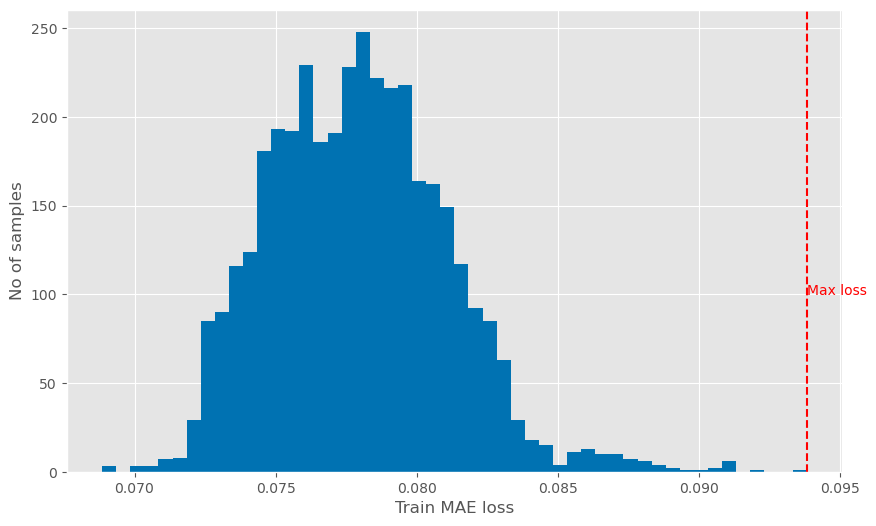

In [360]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the histogram of MAE loss for predictions on training data.
ax.hist(train_mae_loss, bins=50)
# Set the x-axis label.
ax.set_xlabel("Train MAE loss")
# Set the y-axis label.
ax.set_ylabel("No of samples")
# Add a vertical dashed line at the maximum loss value.
ax.axvline(x=train_mae_loss.max(), color="red", linestyle="--")
# Add a text label at the maximum loss value.
ax.text(x=train_mae_loss.max(), y=100, s="Max loss", color="red");

In [361]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# Print the threshold value.
print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 0.0938323250481299


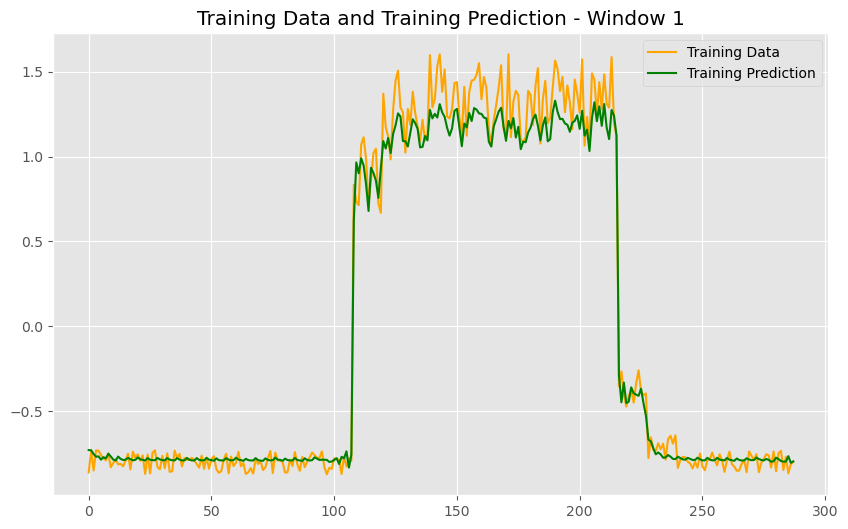

In [362]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first window of the training data.
ax.plot(x_train[0], color="orange", label="Training Data")

# Plot the first window of the training data predictions.
ax.plot(x_train_pred[0], color="green", label="Training Prediction")

# Add a legend.
ax.legend()

# Add a title.
ax.set_title("Training Data and Training Prediction - Window 1");

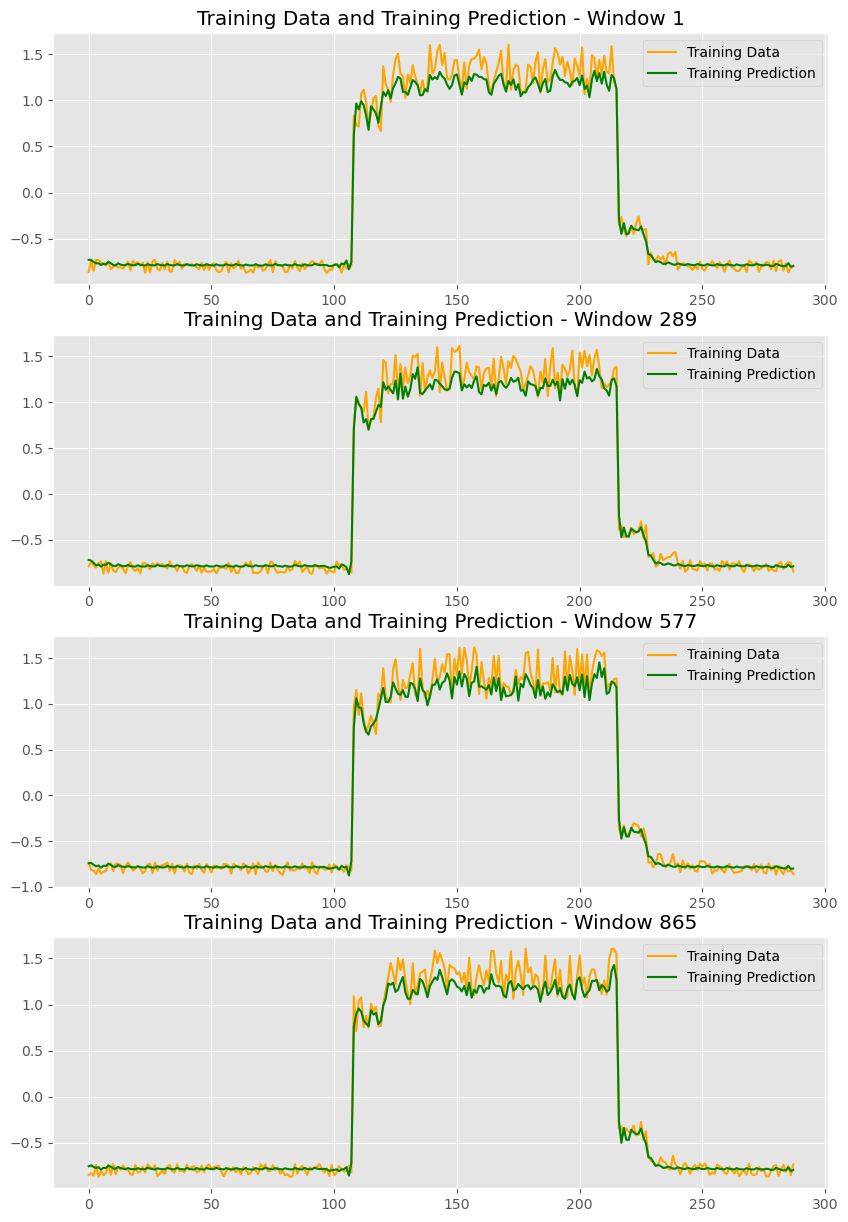

In [364]:
# Plot windows 1, 289, 577, 865 in subplots of 4 rows and 1 column.
# This will give us an idea of the first four consecutive "signals" for the dataset.
fig, axs = plt.subplots(4, 1, figsize=(10, 15))

# Plot the first window of the training data.
axs[0].plot(x_train[0], color="orange", label="Training Data")
# Plot the first window of the training data predictions.
axs[0].plot(x_train_pred[0], color="green", label="Training Prediction")
# Add a legend.
axs[0].legend()
# Add a title.
axs[0].set_title("Training Data and Training Prediction - Window 1")

# Plot the 289th window of the training data.
axs[1].plot(x_train[288], color="orange", label="Training Data")
# Plot the 289th window of the training data predictions.
axs[1].plot(x_train_pred[288], color="green", label="Training Prediction")
# Add a legend.
axs[1].legend()
# Add a title.
axs[1].set_title("Training Data and Training Prediction - Window 289")

# Plot the 577th window of the training data.
axs[2].plot(x_train[576], color="orange", label="Training Data")
# Plot the 577th window of the training data predictions.
axs[2].plot(x_train_pred[576], color="green", label="Training Prediction")
# Add a legend.
axs[2].legend()
# Add a title.
axs[2].set_title("Training Data and Training Prediction - Window 577")

# Plot the 865th window of the training data.
axs[3].plot(x_train[864], color="orange", label="Training Data")
# Plot the 865th window of the training data predictions.
axs[3].plot(x_train_pred[864], color="green", label="Training Prediction")
# Add a legend.
axs[3].legend()
# Add a title.
axs[3].set_title("Training Data and Training Prediction - Window 865");


<p style="color: #001a79;">You'll have noticed from the MAE distribution above that there is a bimodal distribution and right skew. Based on the sub plots of the first four sections of the full signal above, we can see that the variation between the actual data and predicted data is higher for the "peaks" of the signal and lower in the "troughs"</p>

***

<p style="color: #001a79;"><b>Evaluating The Unseen Data with Anomalies</p>
<br><br>
<p style="color: #001a79;">The next step in the evaluation process is to evaluate the model fitted on our unseen anomaly dataset.<br>
The first thing we need to do is pre-process the <code>df_daily_jumpsup</code> dataframe. We use Z-score normalization to scale the data in the same way that we scaled our training data.<br>
Next we have to create our windows using the <code>window</code> function to ensure that the resulting array has ther same shape as the training data had. </p>

In [131]:
# Scale the test data using Z-score normalization.
df_test_value = (df_daily_jumpsup - train_mean) / train_std

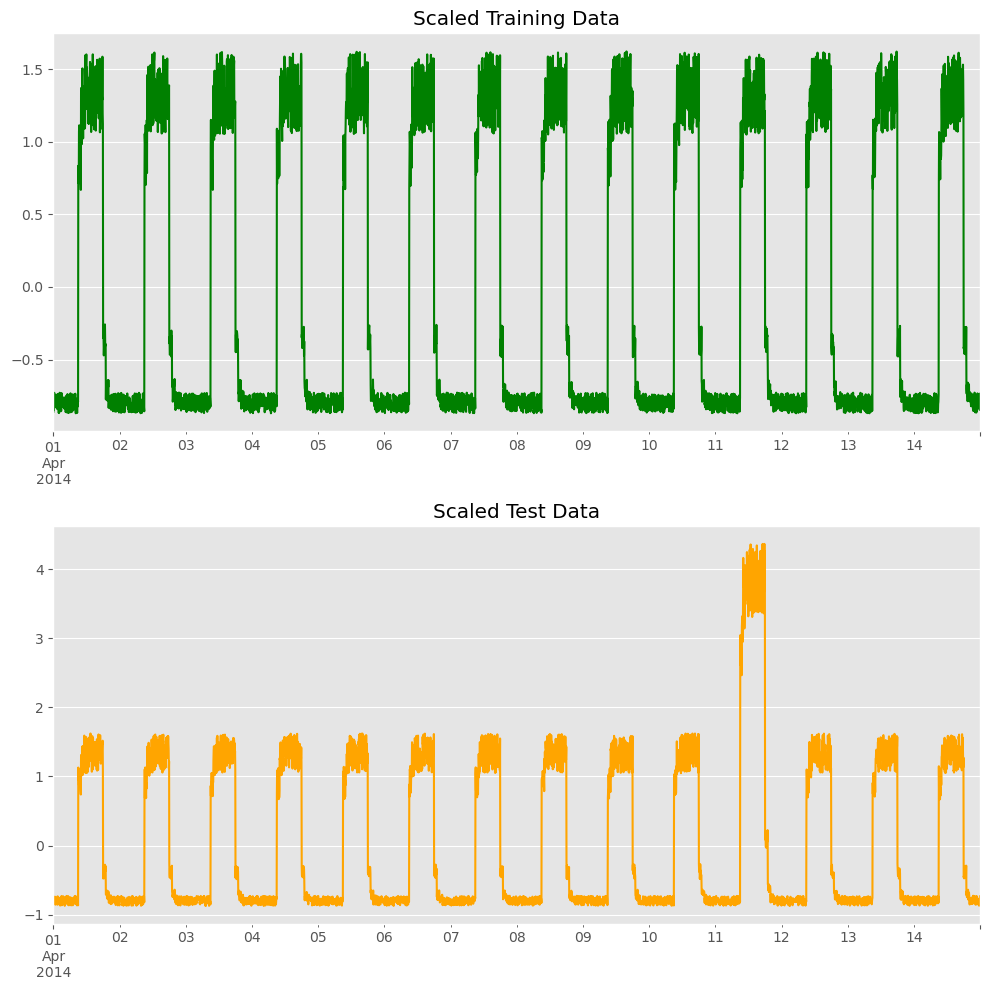

In [375]:
# Visualise the scaled test data and the scaled training data.
# Create a figure with two subplots.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot the scaled training data  from df_test_vals.
df_train_vals.plot(legend=False, ax=ax1, color="green")

# Plot the scaled test data.
df_test_value.plot(legend=False, ax=ax2, color="orange")

# Add a title to the first subplot.
ax1.set_title("Scaled Training Data");

# Add a title to the second subplot.
ax2.set_title("Scaled Test Data")

# Drop x-axis labels from both subplots.
ax1.set_xlabel("")
ax2.set_xlabel("")

# Ensure the subplots are spaced correctly.
fig.tight_layout();


In [379]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

# Check the shape of the test data.
x_test.shape

(3745, 288, 1)

<p style="color: #001a79;">At this point we have scaled the anomaly data and reshaped the dataframe into a 3 Dimensional array.<br>
The next step is to create predictions on the x_test array using our model. </p>

In [380]:
# Generate predictions for the test data. 
x_test_pred = model.predict(x_test)

118/118 [==============================] - 0s 4ms/step


In [381]:
# Calculate Mean absolute error loss for predictions on test data.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

# Print out a sample of the test MAE loss.
test_mae_loss

array([[0.07722147],
       [0.07895581],
       [0.07675484],
       ...,
       [0.07740857],
       [0.07904439],
       [0.07732811]])

In [382]:
test_mae_loss.shape

(3745, 1)

In [383]:
# Reshape the test MAE Loss array from 2D to 1D.
test_mae_loss = test_mae_loss.reshape((-1))

# Sanity check the shape of the test MAE Loss array.
test_mae_loss

array([0.07722147, 0.07895581, 0.07675484, ..., 0.07740857, 0.07904439,
       0.07732811])

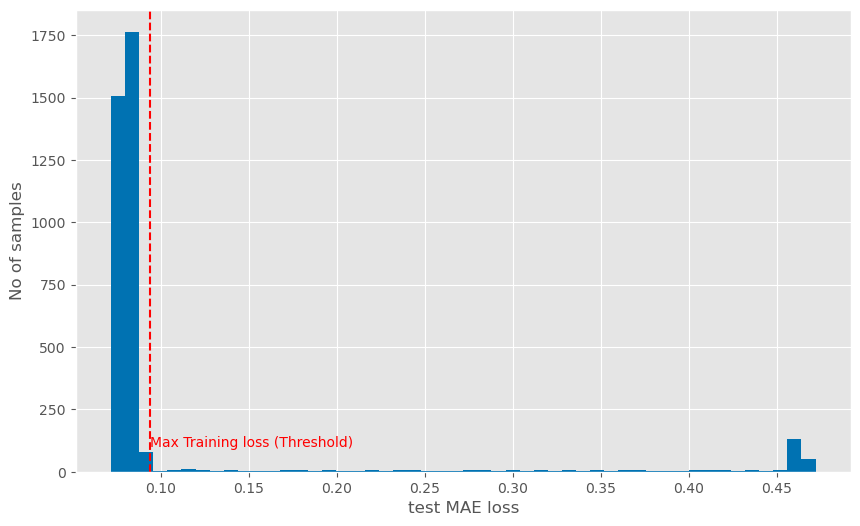

In [388]:
# Create a figure and axis. 
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram of MAE loss for predictions on test data.
ax.hist(test_mae_loss, bins=50)

# Set the x-axis label.
ax.set_xlabel("test MAE loss")

# Set the y-axis label.
ax.set_ylabel("No of samples")

# Add a vertical dashed line at the maximum loss value of the train_mae_loss array
ax.axvline(x=train_mae_loss.max(), color="red", linestyle="--")

# Add a text label at the maximum loss value.
ax.text(x=train_mae_loss.max(), y=100, s="Max Training loss (Threshold)", color="red");

<p style="color: #001a79;">I have added the max MAE loss for the training data set in the above chart. This makes it clear that there are many samples in the test data set that the model will consider anomalous.<br>
Our next step is to assign all the samples from the test_mae_loss array which are greater than the train_mae_loss maximum value (known as the threshold) to a new array - "anomalies".  </p>

In [386]:
# Detect all the samples which are anomalies.
# If the test MAE loss is greater than the threshold, then the sample is an anomaly.
# An anomaly will be labelled as True, and a normal sample will be labelled as False.
anomalies = test_mae_loss > threshold

# Number of anomalies.
np.sum(anomalies)

398

In [387]:
# Check anomalies array.
anomalies

array([False, False, False, ..., False, False, False])

<p style="color: #001a79;">The following code is used to identify anomalous data in the df_test_value array. It does this by iterating over the data indices and checking if all the data within a certain range of the current index is anomalous, as indicated by the anomalies array. If it is, the current index is added to the anomalous_data_indices list.
<br><br>
The <a href="https://keras.io/examples/timeseries/timeseries_anomaly_detection/">Documentation</a> actually does a reasonable job of explaining this:</p>
<br><br>

> We now know the samples of the data which are anomalies. With this, we will find the corresponding timestamps from the original test data. We will be using the following method to do that:<br>
> 
> Let's say time_steps = 3 and we have 10 training values. Our x_train will look like this:<br>
>
> 0, 1, 2<br>
> 1, 2, 3<br>
> 2, 3, 4<br>
> 3, 4, 5<br>
> 4, 5, 6<br>
> 5, 6, 7<br>
> 6, 7, 8<br>
> 7, 8, 9<br>
<br>
> All except the initial and the final time_steps-1 data values, will appear in time_steps number of samples. So, if we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point 5 is an anomaly.

In [389]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
# Declare an empty list to store the indices of anomalies.
inds = []

# Loop from sample window size - 1 to the end of the test data - 1 index
for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    # if all samples from i - window_size + 1 to i are anomalies
    if np.all(anomalies[i - window_size + 1 : i]):
        # Append the index at position i to the list of indices.
        inds.append(i)

In [397]:
# Detemine start and end index of anomalies.
print(f'The first anomaly starts at index {inds[0]} and ends at index {inds[-1]}')


The first anomaly starts at index 2988 and ends at index 3096


In [398]:
# Create a new dataframe of anomalies.
# This statement will select and return all the rows
# in df_daily_jumpsup where the index is in the list of indices.
df_subset = df_daily_jumpsup.iloc[inds]

# Sanity check.
df_subset.head()

,value
timestamp,
2014-04-11 09:00:00,127.882020134000001
2014-04-11 09:05:00,115.705718857999997
2014-04-11 09:10:00,122.386410329000000
2014-04-11 09:15:00,127.261177846000010
2014-04-11 09:20:00,121.157997338999991


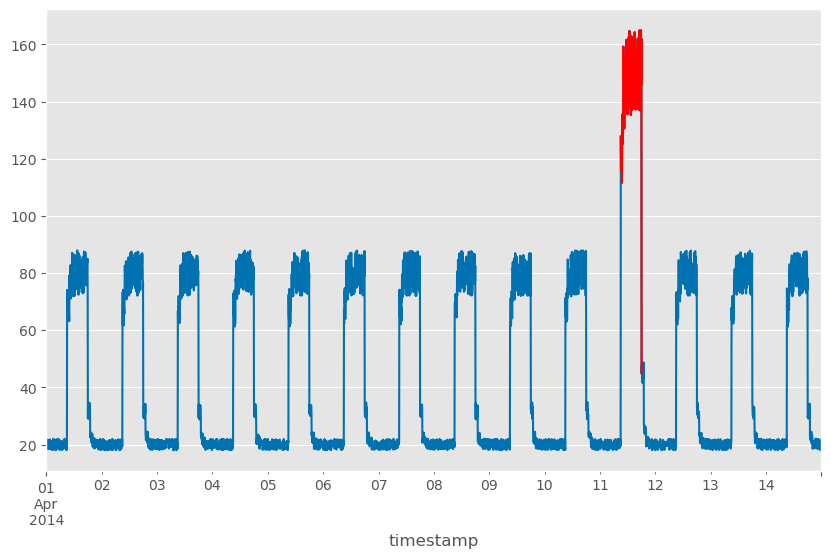

In [399]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the daily jumps up data.
df_daily_jumpsup.plot(legend=False, ax=ax)

# Overlay the anomalies from the df_subset dataframe.
df_subset.plot(legend=False, ax=ax, color="r");

References:

1. Goodfellow, I.; Bengio, Y. & Courville, A. (2016), Deep Learning , MIT Press.
2. Wood, T. (Date Unknown), Activation Functions, Available at:https://deepai.org/machine-learning-glossary-and-terms/activation-function (Accessed Dec 2022) 
3. Anwar, A., What is Transposed Convolutional Layer (2020). Available at: https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11 (Accessed Dec 2022)
4. Stojiljkovic, M. (2021) Stochastic Gradient Descent Algorithm With Python and NumPy, Available at: https://realpython.com/gradient-descent-algorithm-python/ (Accessed Dec 2022)
5. Kingma, D. & Ba, J. (2015) Adam: A Method for Stochastic Optimization, Available at: https://arxiv.org/abs/1412.6980 (Accessed Dec 2022)
5. Karpathy, A. (2016) CS231n: Convolutional Neural Networks for Visual Recognition, Available at: https://cs231n.github.io/optimization-2/ (Accessed Dec 2022)
6. Pramoditha, R., (2022) All You Need to Know about Batch Size, Epochs and Training Steps in a Neural Network. Available at: https://rukshanpramoditha.medium.com/all-you-need-to-know-about-batch-size-epochs-and-training-steps-in-a-neural-network-f592e12cdb0a. (Accessed Dec 2022)
7. Brownlee, J. (2019) Learning Curves for Diagnosing Machine Learning Model Performance. Available at: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/ (Accessed Dec 2022)
8. Goodfellow, I., Bengio, Y., Courville, A. (2016) Deep Learning. Available at: https://www.deeplearningbook.org/contents/ml.html (Accessed Dec 2022)
9. Trevisan, M. (2022) Comparing Robustness of MAE, MSE and RMSE. Available at: https://towardsdatascience.com/comparing-robustness-of-mae-mse-and-rmse-6d69da870828 (Accessed Dec 2022)
10. Dau, Anh & Ciesielski, Vic & Song, Andy. (2014). Anomaly Detection Using Replicator Neural Networks Trained on Examples of One Class. 311-322. 10.1007/978-3-319-13563-2_27. 